## Importing required libraries

In [1]:
# Packages for dataframe operations
import numpy as np 
import pandas as pd
# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import collections

import re
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\Aditya Kabra\AppData\Roaming\Python\Python38\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior an

##  Analysing and Pre-processing  data

In [2]:
df = pd.read_csv('data.csv') 

In [3]:
#Data Cleaning
#Delete a column not needed 
df.reset_index(drop=True)
del df['Unnamed: 0']

In [4]:
df.isnull().sum()

Job Title            0
Salary Estimate      0
Job Description      0
Rating               0
Company Name         1
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
Competitors          0
Easy Apply           0
dtype: int64

In [5]:
# fill the NA with -1
df.fillna(-1,inplace=True)

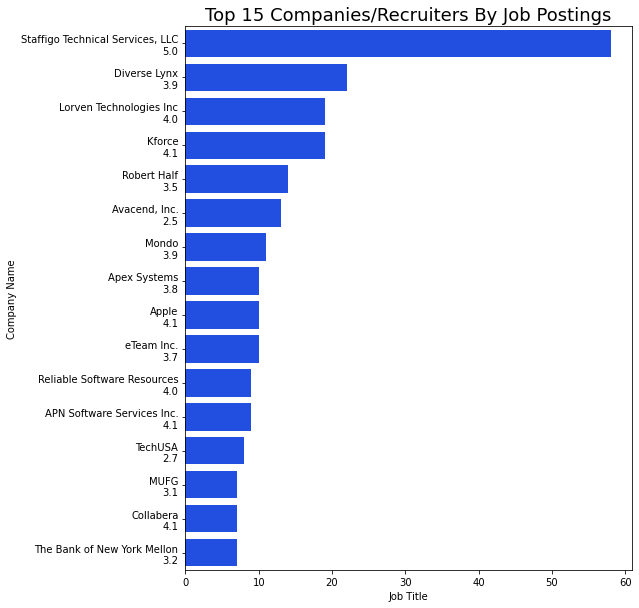

In [6]:

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 10))

#Dataset relating to recruiters
rec_df = df.groupby('Company Name').count().sort_values(by='Job Title', ascending=False).reset_index()[['Company Name', 'Job Title']].copy()

# Plot the total crashes
sns.set_color_codes("bright")
sns.barplot(x="Job Title", y="Company Name", data=rec_df.loc[0:15,:],
            label="Total", color="b")

plt.title('Top 15 Companies/Recruiters By Job Postings', fontsize=18);

In [7]:
df.columns = df.columns.str.replace(' ','_')

In [8]:
#Set to lower case so capitalised titles don't get counted separately
df['Job_Title'] = df['Job_Title'].apply(lambda x: x.lower())

#Group by Role to investigate different types
df_grp = df.groupby('Job_Title').count().reset_index().sort_values(by='Company_Name', ascending=False)[['Job_Title', 'Company_Name']]

print("Number of unique job roles:", df_grp.shape[0])

print("Number of titles used more than once:", df_grp[df_grp.Company_Name> 1].shape[0])

df_grp[df_grp.Company_Name> 2]

Number of unique job roles: 1257
Number of titles used more than once: 192


,Job_Title,Company_Name
220,data analyst,411
978,senior data analyst,92
759,junior data analyst,30
136,business data analyst,28
1144,sr. data analyst,21
...,...,...
661,epidemiology data analyst,3
604,data visualization analyst,3
1065,senior product data analyst,3
598,data systems analyst,3


## Type of role based on keywords in the Job title

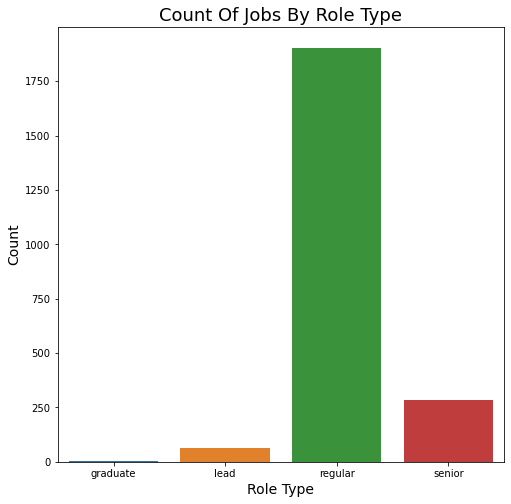

In [9]:
# Function to return the type of role based on keywords in the title.
def role_type(x):
    if 'lead' in x:
        return 'lead'
    elif 'head' in x:
        return 'lead'
    elif 'chief' in x:
        return 'lead'
    elif 'senior' in x:
        return 'senior'
    elif 'graduate' in x:
        return 'graduate'
    else:
        return 'regular'
    
df['Role_Type'] = df['Job_Title'].apply(role_type)

job_df = df.groupby('Role_Type').count().reset_index()[['Role_Type', 'Job_Title']]

f, ax = plt.subplots(figsize=(8, 8))

sns.barplot(x='Role_Type', y='Job_Title', data=job_df)

ax.set_title('Count Of Jobs By Role Type', fontsize=18)
ax.set_xlabel('Role Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14);

In [10]:
# group by role type
groups = df.groupby(df.Role_Type)
df.regular = groups.get_group("regular")
df.senior=groups.get_group("senior")

<ipython-input-10-1a3b291366c4>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.regular = groups.get_group("regular")
<ipython-input-10-1a3b291366c4>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.senior=groups.get_group("senior")


In [11]:
from nltk.corpus import stopwords
# defining stop words
stop_words = stopwords.words('english')


e= ['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 
                   'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 
                   'line', 'even', 'also', 'may', 'take', 'come', 'from', 'subject', 're', 'edu', 'use', 'data', 'data analyst', 'business',
                  'analyst', 'role', 'function', 'application', 'recruit', 'recruitment', 'skill',
                  'work', 'applicant', 'job', 'email', 'send', 'resume', 'phone', 'cover_letter', 'apply', 'day', 'looking',
                  'hire']

stop_words.extend(e)

### Tokenize Sentences and Clean

In [12]:
# for regular role
# Remove Emails
data1 = [re.sub('\S*@\S*\s?', '', sent) for sent in df.regular.Job_Description]

# Remove new line characters
data1 = [re.sub('\s+', ' ', sent) for sent in df.regular.Job_Description]

# Remove distracting single quotes
data1 = [re.sub("\'", "", sent) for sent in df.regular.Job_Description]

# Remove distracting ""\n" quotes
#data = [re.sub("\n", "", sent) for sent in df.Job_Description]
pprint(data1[:1])

['Are you eager to roll up your sleeves and harness data to drive policy '
 'change? Do you enjoy sifting through complex datasets to illuminate trends '
 'and insights? Do you see yourself working for a values-driven organization '
 'with a vision to tackle the most pressing injustices of our day?\n'
 '\n'
 'We are looking to hire a bright, hard-working, and creative individual with '
 'strong data management skills and a demonstrated commitment to immigrants '
 'rights. The Data Analyst will assist with analysis and reporting needs for '
 'Veras Center on Immigration and Justice (CIJ), working across its current '
 'projects and future Vera initiatives.\n'
 '\n'
 'Who we are:\n'
 '\n'
 'Founded in 1961, The Vera Institute is an independent, non-partisan, '
 'nonprofit organization that combines expertise in research, technical '
 'assistance, and demonstration projects to assist leaders in government and '
 'civil society examine justice policy and practice, and improve the systems '

In [13]:
# for senior role
# Remove Emails
data2 = [re.sub('\S*@\S*\s?', '', sent) for sent in df.senior.Job_Description]

# Remove new line characters
data2 = [re.sub('\s+', ' ', sent) for sent in df.senior.Job_Description]

# Remove distracting single quotes
data2 = [re.sub("\'", "", sent) for sent in df.senior.Job_Description]

# Remove distracting ""\n" quotes
#data = [re.sub("\n", "", sent) for sent in df.Job_Description]

In [14]:
# for regular role
def sent_to_words1(sentences1):
    for sentences in sentences1:
        yield(gensim.utils.simple_preprocess(str(sentences), deacc=True))  # deacc=True removes punctuations

data_words1 = list(sent_to_words1(data1))

print(data_words1[:1])

[['are', 'you', 'eager', 'to', 'roll', 'up', 'your', 'sleeves', 'and', 'harness', 'data', 'to', 'drive', 'policy', 'change', 'do', 'you', 'enjoy', 'sifting', 'through', 'complex', 'datasets', 'to', 'illuminate', 'trends', 'and', 'insights', 'do', 'you', 'see', 'yourself', 'working', 'for', 'values', 'driven', 'organization', 'with', 'vision', 'to', 'tackle', 'the', 'most', 'pressing', 'injustices', 'of', 'our', 'day', 'we', 'are', 'looking', 'to', 'hire', 'bright', 'hard', 'working', 'and', 'creative', 'individual', 'with', 'strong', 'data', 'management', 'skills', 'and', 'demonstrated', 'commitment', 'to', 'immigrants', 'rights', 'the', 'data', 'analyst', 'will', 'assist', 'with', 'analysis', 'and', 'reporting', 'needs', 'for', 'veras', 'center', 'on', 'immigration', 'and', 'justice', 'cij', 'working', 'across', 'its', 'current', 'projects', 'and', 'future', 'vera', 'initiatives', 'who', 'we', 'are', 'founded', 'in', 'the', 'vera', 'institute', 'is', 'an', 'independent', 'non', 'parti

In [15]:
# for senior role
def sent_to_words2(sentences12):
    for sentences1 in sentences12:
        yield(gensim.utils.simple_preprocess(str(sentences1), deacc=True))  # deacc=True removes punctuations

data_words2 = list(sent_to_words2(data2))

print(data_words2[:1])

[['we', 're', 'looking', 'for', 'senior', 'data', 'analyst', 'who', 'has', 'love', 'of', 'mentorship', 'data', 'visualization', 'and', 'generating', 'actionable', 'insights', 'from', 'raw', 'data', 'in', 'this', 'role', 'you', 'll', 'have', 'the', 'opportunity', 'to', 'be', 'an', 'organizational', 'influencer', 'who', 'will', 'generate', 'insights', 'with', 'good', 'degree', 'of', 'autonomy', 'and', 'partner', 'with', 'data', 'science', 'to', 'grow', 'deeper', 'analytical', 'skills', 'you', 'will', 'be', 'joining', 'the', 'insights', 'analytics', 'team', 'team', 'tasked', 'with', 'developing', 'insights', 'and', 'reporting', 'to', 'support', 'our', 'customers', 'and', 'advisors', 'needs', 'this', 'team', 'sits', 'within', 'the', 'customer', 'operations', 'team', 'but', 'is', 'also', 'connected', 'to', 'the', 'product', 'organization', 'in', 'this', 'role', 'you', 'will', 'work', 'mainly', 'with', 'customer', 'operations', 'stakeholders', 'to', 'set', 'kpis', 'and', 'evaluate', 'the', '

### Build the Bigram, Trigram Models and Lemmatize

In [16]:
# for regular role
# Build the bigram and trigram models
bigram1 = gensim.models.Phrases(data_words1, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram1 = gensim.models.Phrases(bigram1[data_words1], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod1 = gensim.models.phrases.Phraser(bigram1)
trigram_mod1 = gensim.models.phrases.Phraser(trigram1)

# See trigram example
print(trigram_mod1[bigram_mod1[data_words1[0]]])

C:\Users\Aditya Kabra\AppData\Roaming\Python\Python38\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['are', 'you', 'eager', 'to', 'roll_up', 'your', 'sleeves', 'and', 'harness', 'data', 'to', 'drive', 'policy', 'change', 'do', 'you', 'enjoy', 'sifting', 'through', 'complex', 'datasets', 'to', 'illuminate', 'trends', 'and', 'insights', 'do', 'you', 'see', 'yourself', 'working', 'for', 'values', 'driven', 'organization', 'with', 'vision', 'to', 'tackle', 'the', 'most_pressing', 'injustices', 'of', 'our', 'day', 'we', 'are', 'looking', 'to', 'hire', 'bright', 'hard', 'working', 'and', 'creative', 'individual', 'with', 'strong', 'data', 'management', 'skills', 'and', 'demonstrated', 'commitment', 'to', 'immigrants', 'rights', 'the', 'data', 'analyst', 'will', 'assist', 'with', 'analysis', 'and', 'reporting', 'needs', 'for', 'veras', 'center', 'on', 'immigration', 'and', 'justice', 'cij', 'working', 'across', 'its', 'current', 'projects', 'and', 'future', 'vera', 'initiatives', 'who', 'we', 'are', 'founded', 'in', 'the', 'vera', 'institute', 'is', 'an', 'independent', 'non', 'partisan', '

In [17]:
# for senior role

# Build the bigram and trigram models
bigram2 = gensim.models.Phrases(data_words2, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram2 = gensim.models.Phrases(bigram2[data_words2], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod2 = gensim.models.phrases.Phraser(bigram2)
trigram_mod2 = gensim.models.phrases.Phraser(trigram2)

# See trigram example
print(trigram_mod2[bigram_mod2[data_words2[0]]])

['we', 're', 'looking', 'for', 'senior', 'data', 'analyst', 'who', 'has', 'love', 'of', 'mentorship', 'data', 'visualization', 'and', 'generating', 'actionable', 'insights', 'from', 'raw', 'data', 'in', 'this', 'role', 'you', 'll', 'have', 'the', 'opportunity', 'to', 'be', 'an', 'organizational', 'influencer', 'who', 'will', 'generate', 'insights', 'with', 'good', 'degree', 'of', 'autonomy', 'and', 'partner', 'with', 'data', 'science', 'to', 'grow', 'deeper', 'analytical', 'skills', 'you', 'will', 'be', 'joining', 'the', 'insights', 'analytics', 'team', 'team', 'tasked', 'with', 'developing', 'insights', 'and', 'reporting', 'to', 'support', 'our', 'customers', 'and', 'advisors', 'needs', 'this', 'team', 'sits', 'within', 'the', 'customer', 'operations', 'team', 'but', 'is', 'also', 'connected', 'to', 'the', 'product', 'organization', 'in', 'this', 'role', 'you', 'will', 'work', 'mainly', 'with', 'customer', 'operations', 'stakeholders', 'to', 'set', 'kpis', 'and', 'evaluate', 'the', 'e

In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords1(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams1(texts):
    return [bigram_mod1[doc] for doc in texts]

def make_trigrams1(texts):
    return [trigram_mod1[bigram_mod1[doc]] for doc in texts]

def lemmatization1(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords2(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams2(texts):
    return [bigram_mod1[doc] for doc in texts]

def make_trigrams2(texts):
    return [trigram_mod1[bigram_mod1[doc]] for doc in texts]

def lemmatization2(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# for regular
# Remove Stop Words
data_words_nostops1 = remove_stopwords1(data_words1)

# Form Bigrams
data_words_bigrams1 = make_bigrams1(data_words_nostops1)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized1 = lemmatization1(data_words_bigrams1, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized1[:1])

[['eager', 'roll', 'sleeve', 'harness', 'drive', 'policy', 'change', 'enjoy', 'sift', 'complex', 'dataset', 'illuminate', 'trend', 'insight', 'work', 'value', 'drive', 'organization', 'vision', 'tackle', 'press', 'injustice', 'bright', 'hard', 'work', 'creative', 'individual', 'strong', 'management', 'skill', 'demonstrate', 'commitment', 'immigrant', 'right', 'assist', 'analysis', 'report', 'need', 'veras', 'center', 'immigration', 'justice', 'cij', 'work', 'current', 'project', 'future', 'vera', 'initiative', 'found', 'vera', 'institute', 'independent', 'non', 'partisan', 'nonprofit', 'organization', 'combine', 'expertise', 'research', 'technical', 'assistance', 'demonstration', 'project', 'assist', 'leader', 'government', 'civil', 'society', 'examine', 'justice', 'policy', 'practice', 'improve', 'system', 'people', 'rely', 'justice', 'safety', 'study', 'problem', 'impede', 'human', 'dignity', 'justice', 'pilot', 'solution', 'transformative', 'achievable', 'engage', 'diverse', 'commun

In [21]:
#for senior
# Remove Stop Words
data_words_nostops2 = remove_stopwords2(data_words2)

# Form Bigrams
data_words_bigrams2 = make_bigrams2(data_words_nostops2)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized2 = lemmatization2(data_words_bigrams2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized2[:1])

[['senior', 'love', 'mentorship', 'visualization', 'generate', 'actionable', 'insight', 'raw', 'opportunity', 'organizational', 'influencer', 'generate', 'insight', 'degree', 'autonomy', 'partner', 'science', 'grow', 'deep', 'analytical', 'skill', 'join', 'insight', 'analytic', 'team', 'team', 'task', 'develop', 'insight', 'report', 'support', 'customer', 'advisor', 'need', 'team', 'sit', 'customer', 'operation', 'team', 'connected', 'product', 'organization', 'mainly', 'customer', 'operation', 'stakeholder', 'set', 'kpi', 'evaluate', 'effectiveness', 'current', 'strategy', 'workflow', 'involve', 'aspect', 'operation', 'auditing', 'building', 'dashboard', 'analytical', 'insight', 'example', 'review', 'code', 'junior', 'analyst', 'organize', 'code', 'workshop', 'build', 'metric', 'evaluate', 'performance', 'advisor', 'eliminate', 'confounding', 'variable', 'create', 'weight', 'measure', 'account', 'individual', 'success', 'define', 'metric', 'create', 'dashboard', 'track', 'success', 'c

## lda for regular role

In [22]:
# Create Dictionary
id2word1 = corpora.Dictionary(data_lemmatized1)

# Create Corpus
texts1 = data_lemmatized1

# Term Document Frequency
corpus1 = [id2word1.doc2bow(texts) for texts in texts1]

# View
print(corpus1[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 4), (15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 1), (21, 3), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 4), (39, 1), (40, 2), (41, 1), (42, 6), (43, 4), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 2), (50, 1), (51, 2), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 3), (60, 1), (61, 1), (62, 1), (63, 3), (64, 2), (65, 1), (66, 1), (67, 1), (68, 3), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 2), (75, 1), (76, 6), (77, 3), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 3), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 2), (92, 1), (93, 1), (94, 3), (95, 1), (96, 1), (97, 3), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [23]:
# Human readable format of corpus (term-frequency)
[[(id2word1[id], freq) for id, freq in cp] for cp in corpus1[:1]]

[[('ability', 2),
  ('able', 1),
  ('access', 1),
  ('achievable', 1),
  ('additional', 2),
  ('address', 1),
  ('administer', 1),
  ('advance', 1),
  ('advocate', 1),
  ('affect', 2),
  ('affirmative_action', 1),
  ('age', 1),
  ('agenda', 1),
  ('agreement', 1),
  ('analysis', 4),
  ('analyst', 1),
  ('anomaly', 1),
  ('applicant', 2),
  ('application', 2),
  ('arrest', 1),
  ('assign', 1),
  ('assist', 3),
  ('assistance', 2),
  ('attach', 1),
  ('attention', 1),
  ('attn', 1),
  ('aws', 1),
  ('background', 1),
  ('base', 1),
  ('basis', 1),
  ('bright', 1),
  ('brooklyn', 1),
  ('build', 2),
  ('call', 1),
  ('career', 1),
  ('caregiver', 1),
  ('carry', 1),
  ('caspio', 1),
  ('center', 4),
  ('change', 1),
  ('child', 2),
  ('children', 1),
  ('cij', 6),
  ('citizen', 4),
  ('citizenship', 1),
  ('civil', 1),
  ('clean', 1),
  ('clearance', 2),
  ('close', 1),
  ('code', 2),
  ('codebook', 1),
  ('collaboration', 2),
  ('collaboratively', 2),
  ('collective', 1),
  ('combine', 1

In [24]:
# Build LDA model
lda_model1 = gensim.models.ldamodel.LdaModel(corpus=corpus1,
                                           id2word=id2word1,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [25]:
# Print the Keyword in the 11 topics
pprint(lda_model1.print_topics())
doc_lda1 = lda_model1[corpus1]

[(0,
  '0.104*"oracle" + 0.023*"odc" + 0.021*"contract" + 0.020*"com" + '
  '0.019*"lead" + 0.019*"description" + 0.018*"bull" + 0.017*"location" + '
  '0.016*"candidate" + 0.016*"controller"'),
 (1,
  '0.026*"health" + 0.024*"research" + 0.019*"analysis" + 0.018*"healthcare" + '
  '0.013*"clinical" + 0.013*"care" + 0.011*"experience" + 0.010*"statistical" '
  '+ 0.010*"include" + 0.008*"patient"'),
 (2,
  '0.042*"quality" + 0.029*"governance" + 0.027*"security" + '
  '0.027*"management" + 0.026*"master" + 0.024*"process" + 0.021*"standard" + '
  '0.019*"sap" + 0.015*"configuration" + 0.014*"enterprise"'),
 (3,
  '0.015*"model" + 0.015*"engineering" + 0.014*"science" + 0.014*"risk" + '
  '0.012*"optimum" + 0.012*"machine_learne" + 0.011*"credit" + '
  '0.010*"algorithm" + 0.010*"python" + 0.008*"market"'),
 (4,
  '0.016*"disability" + 0.015*"employer" + 0.014*"company" + '
  '0.013*"employment" + 0.012*"status" + 0.012*"opportunity" + 0.010*"include" '
  '+ 0.010*"client" + 0.009*"empl

In [26]:
# Compute Perplexity
print('\nPerplexity: ', lda_model1.log_perplexity(corpus1))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda1 = CoherenceModel(model=lda_model1, texts=data_lemmatized1, dictionary=id2word1, coherence='c_v')
coherence_lda1 = coherence_model_lda1.get_coherence()
print('\nCoherence Score: ', coherence_lda1)


Perplexity:  -7.357482186806045

Coherence Score:  0.4508603389807843


## lda for senior role

In [27]:
# Create Dictionary
id2word2 = corpora.Dictionary(data_lemmatized2)

# Create Corpus
texts2 = data_lemmatized2

# Term Document Frequency
corpus2= [id2word2.doc2bow(texts1) for texts1 in texts2]

# View
print(corpus2[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 3), (5, 1), (6, 3), (7, 1), (8, 5), (9, 3), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 3), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 3), (46, 9), (47, 3), (48, 1), (49, 1), (50, 2), (51, 1), (52, 2), (53, 1), (54, 3), (55, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 3), (74, 1), (75, 1), (76, 1), (77, 3), (78, 1), (79, 1), (80, 1), (81, 1), (82, 8), (83, 1), (84, 1), (85, 1), (86, 2), (87, 1), (88, 1), (89, 3), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 3), (101, 2), (102, 1), (103, 1), (104, 8), (105, 1), (106, 2), (107, 1), (108, 1), (109, 1), (110, 1)

In [28]:
# Human readable format of corpus (term-frequency)
[[(id2word2[id], freq) for id, freq in cp] for cp in corpus2[:1]]

[[('account', 1),
  ('act', 1),
  ('actionable', 2),
  ('advanced', 1),
  ('advisor', 3),
  ('age', 1),
  ('analysis', 3),
  ('analyst', 1),
  ('analytic', 5),
  ('analytical', 3),
  ('analyze', 2),
  ('ancestry', 1),
  ('anyway', 1),
  ('artist', 1),
  ('aspect', 1),
  ('auditing', 1),
  ('autonomy', 1),
  ('bachelor_degree', 1),
  ('base', 2),
  ('beautiful', 1),
  ('bi', 1),
  ('blend', 1),
  ('bot', 1),
  ('broad', 1),
  ('build', 1),
  ('building', 1),
  ('business', 1),
  ('care', 1),
  ('celebrate_diversity', 1),
  ('chatbot', 1),
  ('citizenship', 1),
  ('city', 1),
  ('cleaning', 1),
  ('clear', 1),
  ('clearly', 1),
  ('code', 3),
  ('collaborate', 2),
  ('com', 1),
  ('commit', 1),
  ('communicate', 1),
  ('confounding', 1),
  ('connected', 1),
  ('create', 2),
  ('creative', 1),
  ('culture', 1),
  ('current', 3),
  ('customer', 9),
  ('dashboard', 3),
  ('dashboarding', 1),
  ('dataset', 1),
  ('deep', 2),
  ('define', 1),
  ('degree', 2),
  ('demand', 1),
  ('design', 3),

In [29]:
# Build LDA model
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus2,
                                           id2word=id2word2,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [30]:
# Print the Keyword in the 11 topics
pprint(lda_model2.print_topics())
doc_lda2 = lda_model2[corpus2]

[(0,
  '0.021*"team" + 0.018*"client" + 0.017*"analytic" + 0.017*"solution" + '
  '0.009*"lead" + 0.009*"customer" + 0.008*"core" + 0.008*"chronic" + '
  '0.007*"vida" + 0.007*"condition"'),
 (1,
  '0.017*"content" + 0.013*"square" + 0.012*"financial" + 0.012*"marketing" + '
  '0.010*"provider" + 0.010*"claim" + 0.009*"market" + 0.008*"perficient" + '
  '0.007*"finance" + 0.007*"assist"'),
 (2,
  '0.020*"service" + 0.017*"consumer" + 0.014*"center" + 0.012*"guidewire" + '
  '0.012*"product" + 0.011*"experience" + 0.010*"quality" + 0.010*"medium" + '
  '0.010*"testing" + 0.009*"direct"'),
 (3,
  '0.019*"knowledge" + 0.013*"federal" + 0.012*"acquisition" + '
  '0.011*"contract" + 0.010*"skill" + 0.010*"write" + 0.010*"tax" + '
  '0.009*"seeker" + 0.008*"employment" + 0.008*"method"'),
 (4,
  '0.016*"system" + 0.012*"experience" + 0.010*"information" + 0.010*"require" '
  '+ 0.009*"include" + 0.008*"provide" + 0.008*"employee" + 0.008*"service" + '
  '0.008*"support" + 0.007*"program"'),


In [31]:
# Compute Perplexity
print('\nPerplexity: ', lda_model2.log_perplexity(corpus2))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda2 = CoherenceModel(model=lda_model2, texts=data_lemmatized2, dictionary=id2word2, coherence='c_v')
coherence_lda2 = coherence_model_lda2.get_coherence()
print('\nCoherence Score: ', coherence_lda2)


Perplexity:  -7.29863805751112

Coherence Score:  0.38027536122470007


## Wordcloud

In [32]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

## Wordcloud of Top N words in each topic for regular role

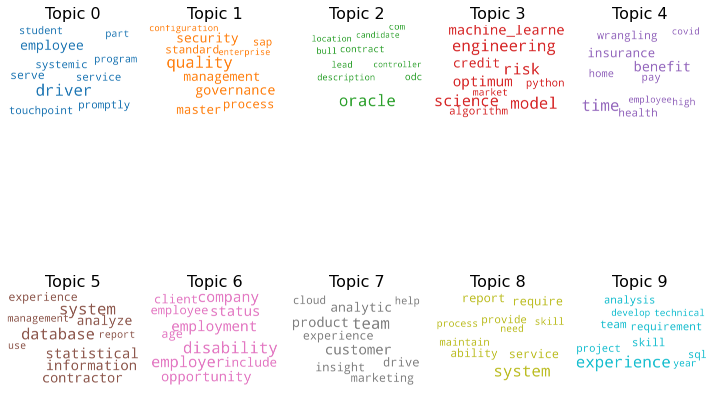

In [33]:
# regular role
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model1.show_topics(formatted=False)

fig, axes = plt.subplots(2,5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


## Wordcloud of Top N words in each topic for senior role

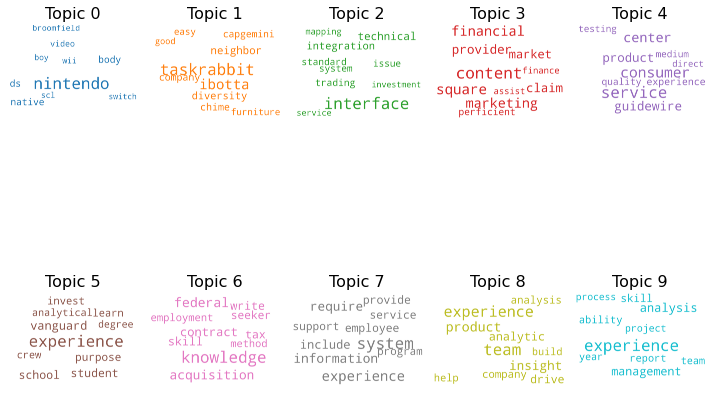

In [34]:
# senior role

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model2.show_topics(formatted=False)

fig, axes = plt.subplots(2,5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
